Quietly install packages for working with point cloud files.

In [1]:
%%capture
!pip install laspy

# Loading and visualizing the dataset

In [2]:
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns

# Field inventory

In [3]:
field_inventory = gpd.read_file("/kaggle/input/tree-detection-lidar-rgb/field_survey.geojson")
field_inventory.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,NaN,POINT (547075.840 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,NaN,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,NaN,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,NaN,POINT (547078.211 6450419.020)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,NaN,POINT (547074.669 6450415.573)


In [4]:
counts = field_inventory.value_counts("species").reset_index()
counts

,species,count
0,Spruce,1144
1,Birch,676
2,Fir,663
3,Aspen,598
4,Tilia,370
5,Alder,121
6,Willow,28
7,Elm,1
8,Pine,1


In [5]:
conifiers = {"Spruce", "Fir", "Pine"}
counts["Type"] = counts["species"].map(lambda x: "Coniferous" if x in conifiers else "Deciduous")

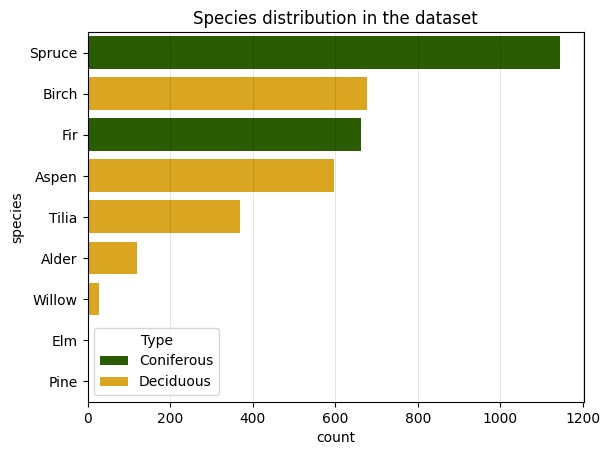

In [6]:
ax = sns.barplot(
    data=counts,
    x="count",
    y="species",
    hue="Type",
    dodge=False,
    hue_order=["Coniferous", "Deciduous"],
    palette=["#2A5C03", "#DAA520"],
    saturation=1,
)
ax.set_title("Species distribution in the dataset")
ax.grid(axis="x", color="black", alpha=0.1)

In [7]:
field_inventory["Type"] = field_inventory["species"].map(lambda x: "Coniferous" if x in conifiers else "Deciduous")

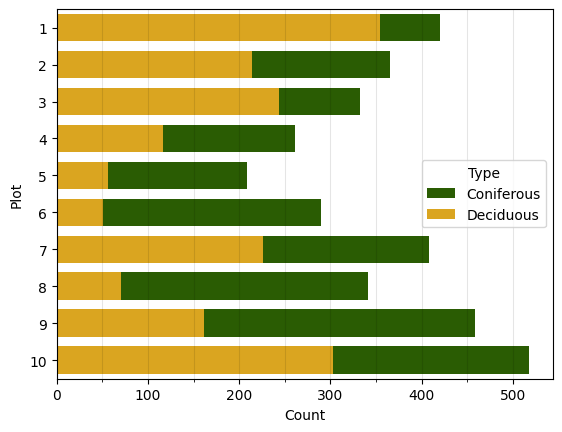

In [8]:
ax = sns.histplot(
    data=field_inventory,
    y="plot",
    discrete=True,
    hue="Type",
    hue_order=["Coniferous", "Deciduous"],
    palette=["#2A5C03", "#DAA520"],
    multiple="stack",
    shrink=0.75,
    alpha=1,
    lw=0,
)
ax.set_ylim(10.5, 0.5)
ax.set_ylabel("Plot")
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
ax.grid(axis="x", color="black", alpha=0.1)
ax.grid(axis="x", which="minor", color="black", alpha=0.1)

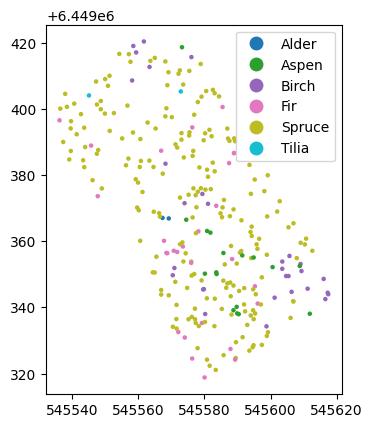

In [9]:
ax = field_inventory.query("plot == 6").plot(
    column="species",
    legend=True,
    s=5,
    aspect="equal",
)

# RGB images

In [10]:
with rasterio.open("/kaggle/input/tree-detection-lidar-rgb/ortho/plot_01.tif") as f:
    p1 = f.read()

with rasterio.open("/kaggle/input/tree-detection-lidar-rgb/ortho/plot_06.tif") as f:
    p6 = f.read()

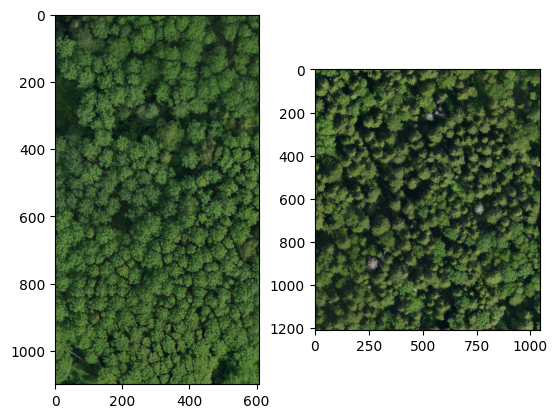

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.rollaxis(p1, 0, 3) / 255.0, clim=(0, 255))
axes[1].imshow(np.rollaxis(p6, 0, 3) / 255.0, clim=(0, 255));

# Point clouds

In [12]:
plot1 = laspy.read("/kaggle/input/tree-detection-lidar-rgb/als/plot_01.las").xyz
plot6 = laspy.read("/kaggle/input/tree-detection-lidar-rgb/als/plot_06.las").xyz

for cloud in (plot1, plot6):
    cloud -= cloud.min(axis=0, keepdims=True)

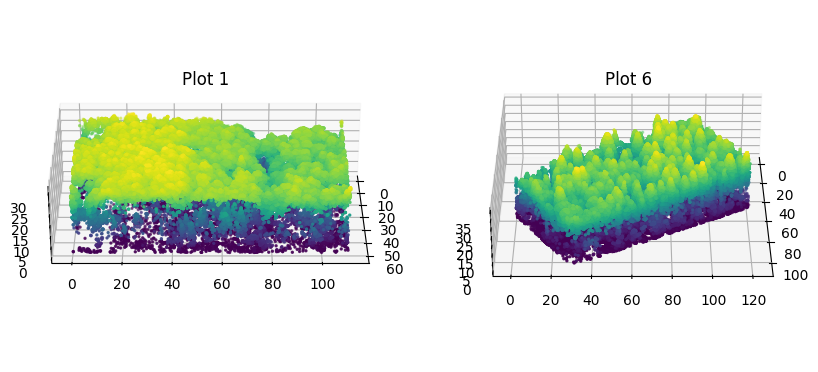

In [13]:
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d")

ax0.scatter(
    *plot1.swapaxes(0, 1),
    c=plot1[:, 2],
    s=2,
)

ax1.scatter(
    *plot6.swapaxes(0, 1),
    c=plot6[:, 2],
    s=2,
)

ax0.view_init(elev=30, azim=0)
ax1.view_init(elev=30, azim=0)

ax0.set_title("Plot 1", y=0.83)
ax1.set_title("Plot 6", y=0.83)

for ax in (ax0, ax1):
    ax.set_aspect("equal")

# Colorized point cloud

In [14]:
cloud6 = laspy.read("/kaggle/input/tree-detection-lidar-rgb/als/plot_06.las").xyz

In [15]:
%%time
with rasterio.open("/kaggle/input/tree-detection-lidar-rgb/ortho/plot_06.tif") as f:
    colors = f.sample(xy=cloud6[:, :2])
    colors = np.stack(list(colors))

CPU times: user 25.5 s, sys: 188 ms, total: 25.7 s
Wall time: 25.8 s


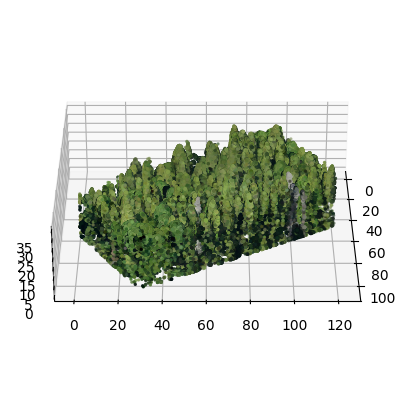

In [16]:
normalized = cloud6 - cloud6.min(axis=0, keepdims=True)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    *normalized.swapaxes(0, 1),
    c=colors / 255.0,
    s=2,
)
ax.view_init(elev=30, azim=0)
ax.set_aspect("equal")